# 주택 가격

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv(r'D:\git_space\data\house_prices\train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(df.shape)
print(df.dtypes.value_counts())
isnull_series = df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

(1460, 81)
object     43
int64      35
float64     3
dtype: int64
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


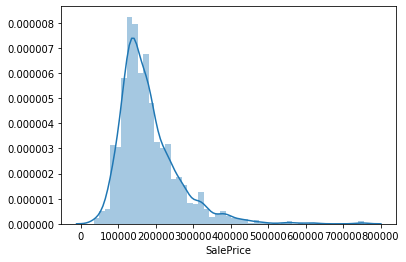

In [5]:
sns.distplot(df['SalePrice'])

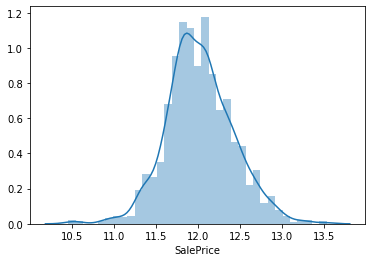

In [6]:
log_saleprice = np.log1p(df['SalePrice'])
sns.distplot(log_saleprice)

In [7]:
original_saleprice = df['SalePrice']
df['SalePrice'] = np.log1p(df['SalePrice'])

df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
df.fillna(df.mean(), inplace=True)
null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
print(df.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [8]:
print(df.shape)
df_ohe = pd.get_dummies(df)
print(df_ohe.shape)
null_column_count = df_ohe.isnull().sum()[df_ohe.isnull().sum() > 0]
print(df_ohe.dtypes[null_column_count.index])

(1460, 75)
(1460, 271)
Series([], dtype: object)


In [23]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)

    print('RMSE: ', rmse)
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)

RMSE:  0.12210090827942026
RMSE:  0.11046853557367392
RMSE:  0.23361541100913916


[0.12210090827942026, 0.11046853557367392, 0.23361541100913916]

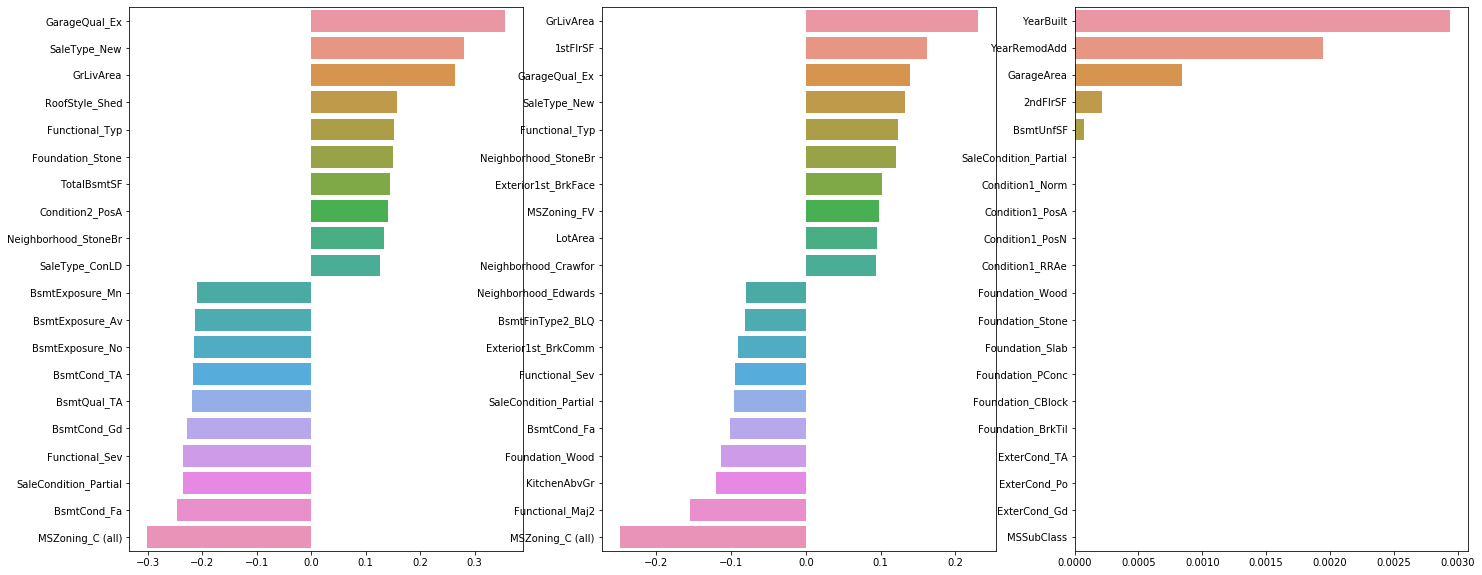

In [24]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visulaize_coeff(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i])

models = [lr, ridge, lasso]
visulaize_coeff(models)

In [26]:
def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print(rmse_list)
        print(rmse_avg)

models = [lr, ridge, lasso]
get_avg_rmse_cv(models)

[0.11510737 0.12835512 0.14196957 0.11257839 0.11826293]
0.12325467671828175
[0.10471039 0.12172811 0.12748428 0.10684112 0.11675109]
0.11550299929830563
[0.22940799 0.25986686 0.25212036 0.25200975 0.25226877]
0.24913474381602324


### 하이퍼 파라미터 수정

In [27]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(rmse)
    print(grid_model.best_params_)

ridge_params = {
    'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]
}

lasso_params = {
    'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]
}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

0.11251434458827023
{'alpha': 8}
0.11221250984226135
{'alpha': 0.001}


RMSE:  0.12210090827942026
RMSE:  0.1097726293896805
RMSE:  0.1082622927898002


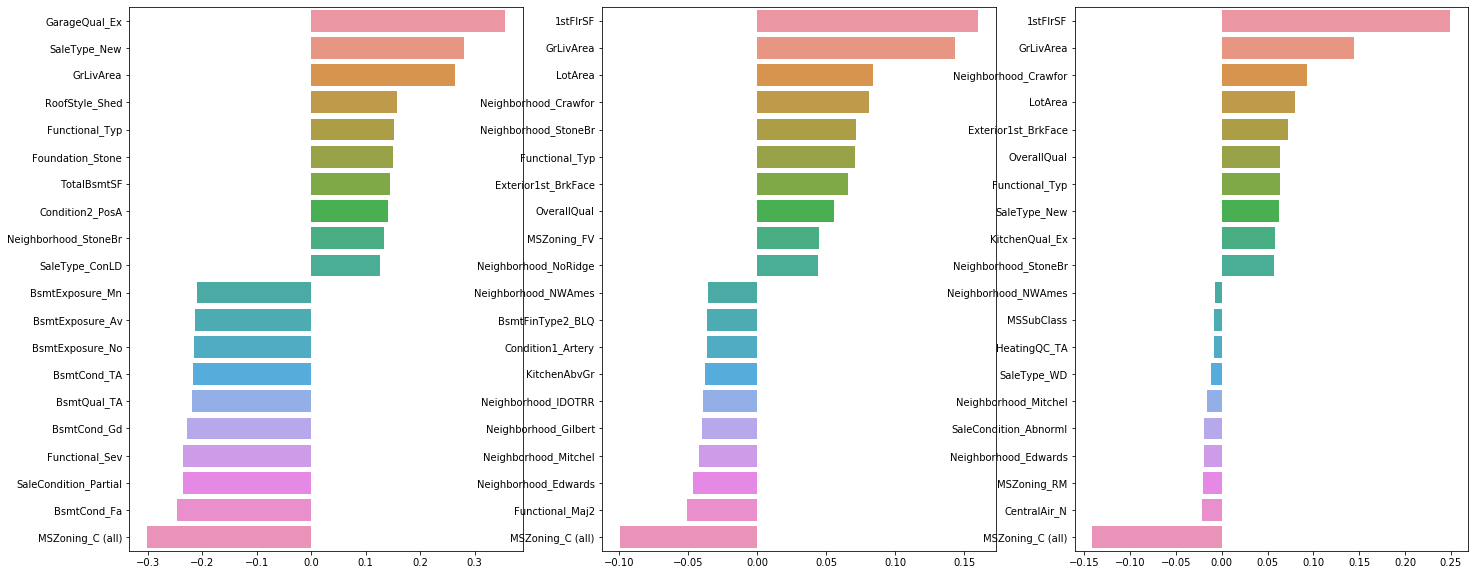

In [28]:
lr = LinearRegression()
ridge = Ridge(alpha=12)
lasso = Lasso(alpha=0.001)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)
visulaize_coeff(models)

In [29]:
# 양의 왜도의 정도 확인
from scipy.stats import skew

features_index = df.dtypes[df.dtypes != 'object'].index
skew_features = df[features_index].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


### 양의 왜도의 모양을 하고 있으므로 log 변환을 취해줌

In [30]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])
df_ohe = pd.get_dummies(df)
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

ridge_params = {
    'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]
}

lasso_params = {
    'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]
}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

0.12755539008066444
{'alpha': 10}
0.12505157232984454
{'alpha': 0.001}


### 양의 왜도가 심한 데이터를 log 변환해 주었더니 더 좋은 성능을 보여준다

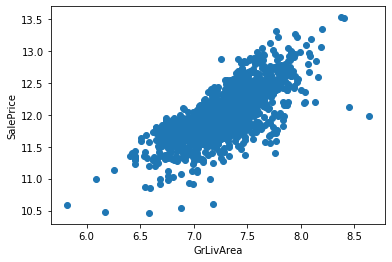

In [31]:
plt.scatter(x=df_ohe['GrLivArea'] , y=df_ohe['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

In [32]:
# outlier 제거
cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index 

print(outlier_index)
print(df_ohe.shape)

df_ohe.drop(outlier_index, axis=0, inplace=True)
print(df_ohe.shape)

Int64Index([523, 1298], dtype='int64')
(1460, 271)
(1458, 271)


In [33]:
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

ridge_params = {
    'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]
}

lasso_params = {
    'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]
}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

0.11248882192171562
{'alpha': 8}
0.11221615802368332
{'alpha': 0.001}


### outlier를 제거 했더니 성능이 조금 더 올라갔다

RMSE:  0.1185351152430321
RMSE:  0.1123594582552018
RMSE:  0.10959182154093419


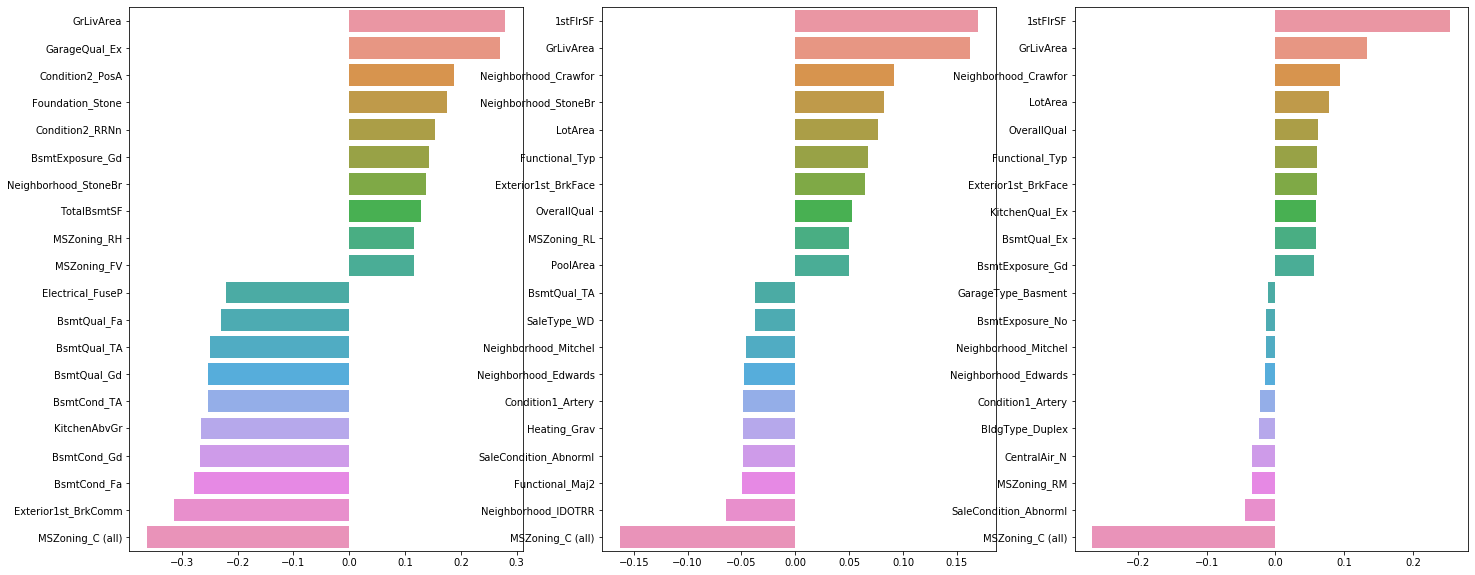

In [34]:
lr = LinearRegression()
ridge = Ridge(alpha=8)
lasso = Lasso(alpha=0.001)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)
visulaize_coeff(models)

In [35]:
from xgboost import XGBRegressor

xgb_params = {
    'n_estimators': [1000]
}

xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb, xgb_params)

[22:48:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.11510299118129141
{'n_estimators': 1000}


In [21]:
from lightgbm import LGBMRegressor

lgbm_parms = {
    'n_estimators': [1000]
}

lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm, lgbm_parms)

0.11632518148855983
{'n_estimators': 1000}


In [22]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print(key, rmse)

ridge = Ridge(alpha=8)
lasso = Lasso(alpha=0.001)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {
    '최종 혼합': pred,
    'Ridge': ridge_pred,
    'Lasso': lasso_pred
}

get_rmse_pred(preds)

최종 혼합 0.13157615362075162
Ridge 0.13155069947370696
Lasso 0.1332772473194331


In [38]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
lgbm_pred = lgbm.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {
    '최종 혼합': pred,
    'XGB': xgb_pred,
    'LGBM': lgbm_pred
}

get_rmse_pred(preds)

[23:35:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 0.1065525588352955
XGB 0.11195241960525477
LGBM 0.10702850239763323


### Stacking Ensemble

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train.shape[0], 1 ))
    test_pred = np.zeros((X_test.shape[0], n_folds))

    for folder_index, (train_index, valid_index) in enumerate(kf.split(X_train)):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[valid_index]
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_index] = model.predict(X_test)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean

X_train_values = X_train.values
X_test_values = X_test.values
y_train_values = y_train.values 

ridge_train, ridge_test = get_stacking_base_datasets(ridge, X_train_values, y_train_values, X_test.values, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso, X_train_values, y_train_values, X_test.values, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb, X_train_values, y_train_values, X_test.values, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm, X_train_values, y_train_values, X_test.values, 5)

final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)
meta_model = Lasso(alpha=0.0005)
meta_model.fit(final_X_train, y_train)
final_pred = meta_model.predict(final_X_test)
mse = mean_squared_error(y_test, final_pred)
rmse = np.sqrt(mse)
print(rmse)

[09:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.10641485713277267


### 스태킹 앙상블 기법이 가장 좋은 성능을 나타냈다